# **Starbucks Udacity Capstone Project**
# Introduction & Data Wrangling
___

#### Introduction
* 1.1 Key Questions

#### Step by step data wrangling
* 2.1 Raw data
* [2.2 Portfolio data](#1.1)
* 2.3 Profile data
* 2.4 Transcript data

#### Scripts
* 3.1. Save file
* 3.2. Wrangle portfolio data
* 3.3. Wrangle profile data
* 3.4. Wrangle transcript data

#### Make Datasets
* 4.1 Perform all data wrangling steps

## Introduction
___
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### 1.1. Key Questions

#### Models
* Can we build a model that given demographic and historical customer data, can predict whether an offer will be completed by a particular customer and to what level of accuracy?
* Can this model be extended to distinguish between responsive offer completions (where a customer views and responds to an offer by actively trying to complete it) vs completing it unintentionally as a results of their normal spending habits?
* Can we further extend the model to predict individual customer spending in reponse to viewing an offer?

#### Summary Findings
* How much do different demographics spend when not influenced by offers?
* Which demographics respond most elastically to which offer types and by how much?
* Can we determine a set of heuristics to distinguish which offers should be sent to which demographics?

## Step by step data wrangling
___

### 2.1. Raw data

**portfolio.json** - containing offer ids and meta data about each offer (duration, type, etc.)
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json** - demographic data for each customer
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json** - records for transactions, offers received, offers viewed, and offers completed
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# mount google drive if running in colab
import os
import sys

if os.path.exists('/usr/lib/python3.6/'):
    from google.colab import drive
    drive.mount('/content/drive/')
    sys.path.append('/content/drive/My Drive/Colab Notebooks/Starbucks_Udacity')
    %cd /content/drive/My Drive/Colab Notebooks/Starbucks_Udacity/notebooks/exploratory
else:
    sys.path.append('../../')

In [2]:
import numpy as np
import pandas as pd
import os
import joblib

# importing scripts
%load_ext autoreload
%autoreload 2
%aimport src.data.make_dataset
%aimport src.utilities.helper

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
portfolio = pd.read_json('../../data/raw/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../../data/raw/profile.json', orient='records', lines=True)
transcript = pd.read_json('../../data/raw/transcript.json', orient='records', lines=True)

In [4]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

### <a id='1.1'>2.2. Portfolio data</a>

In [5]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
# input dataframe and column names to return unique items per column
def uniques(df, column_names):
    for col in df[column_names].columns:
        unique_values = list(sorted(df[col].unique(), reverse=True))
        print("{}: {}".format(col, unique_values, len(unique_values)))

In [7]:
uniques(portfolio, ['difficulty', 'duration', 'offer_type', 'reward'])
print("channel: '[email, mobile, social, web]'")

difficulty: [20, 10, 7, 5, 0]
duration: [10, 7, 5, 4, 3]
offer_type: ['informational', 'discount', 'bogo']
reward: [10, 5, 3, 2, 0]
channel: '[email, mobile, social, web]'


In [8]:
# Converting channels into categories, dropping email since this is common to all channels
portfolio = portfolio.join(portfolio.channels.str.join('|').str.get_dummies())
portfolio.drop(['channels', 'email'], axis=1, inplace=True)

In [9]:
# Changing column order 
portfolio = portfolio[['id', 'difficulty', 'reward', 'duration', 'offer_type', 'mobile', 'web', 'social']]

In [10]:
# Get dummies for offer_type and removing original column
portfolio = portfolio.join(pd.get_dummies(portfolio.offer_type))
portfolio.drop(['offer_type'], axis=1, inplace=True)

In [11]:
# Sorting according to expected effect of offer
portfolio.sort_values(['difficulty', 'reward', 'duration'], ascending=False, inplace=True)
portfolio

,id,difficulty,reward,duration,mobile,web,social,bogo,discount,informational
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,10,0,1,0,0,1,0
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,1,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,0,0
6,fafdcd668e3743c1bb461111dcafc2a4,10,2,10,1,1,1,0,1,0
9,2906b810c7d4411798c6938adc9daaa5,10,2,7,1,1,0,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,3,7,1,1,1,0,1,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,0,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,0,0,1
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,1,0,1,0,0,1


In [12]:
# mapping verbose offer id to simpler format
id = list(portfolio['id'])
portfolio['old_id'] = id
portfolio.id = portfolio.id.map({a:b for a,b in zip(id, 'abcdefghij')})
portfolio.reset_index(drop=True)

,id,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,old_id
0,a,20,5,10,0,1,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
1,b,10,10,7,1,0,1,1,0,0,ae264e3637204a6fb9bb56bc8210ddfd
2,c,10,10,5,1,1,1,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0
3,d,10,2,10,1,1,1,0,1,0,fafdcd668e3743c1bb461111dcafc2a4
4,e,10,2,7,1,1,0,0,1,0,2906b810c7d4411798c6938adc9daaa5
5,f,7,3,7,1,1,1,0,1,0,2298d6c36e964ae4a3e7e9706d1fb8c2
6,g,5,5,7,1,1,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
7,h,5,5,5,1,1,1,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d
8,i,0,0,4,1,1,0,0,0,1,3f207df678b143eea3cee63160fa8bed
9,j,0,0,3,1,0,1,0,0,1,5a8bc65990b245e5a138643cd4eb9837


### 2.3. Profile data

In [13]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
# getting dummies for gender, unknown "None" becomes baseline
profile = profile.join(pd.get_dummies(profile.gender))
profile.drop(['gender'], axis=1, inplace=True)

In [15]:
# converting to datetime
profile.became_member_on = pd.to_datetime(profile.became_member_on, format='%Y%m%d')

In [16]:
# rearranging column order
profile = profile[['id', 'age', 'income', 'became_member_on', 'F', 'M', 'O']]

In [17]:
# renaming id column to person
profile.rename(columns={'id': 'person'}, inplace=True)

In [18]:
profile.head(10)

,person,age,income,became_member_on,F,M,O
0,68be06ca386d4c31939f3a4f0e3dd783,118,NaN,2017-02-12,0,0,0
1,0610b486422d4921ae7d2bf64640c50b,55,112000.0,2017-07-15,1,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,118,NaN,2018-07-12,0,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,2017-05-09,1,0,0
4,a03223e636434f42ac4c3df47e8bac43,118,NaN,2017-08-04,0,0,0
5,e2127556f4f64592b11af22de27a7932,68,70000.0,2018-04-26,0,1,0
6,8ec6ce2a7e7949b1bf142def7d0e0586,118,NaN,2017-09-25,0,0,0
7,68617ca6246f4fbc85e91a2a49552598,118,NaN,2017-10-02,0,0,0
8,389bc3fa690240e798340f5a15918d5c,65,53000.0,2018-02-09,0,1,0
9,8974fc5686fe429db53ddde067b88302,118,NaN,2016-11-22,0,0,0


### 2.4. Transcript data

In [19]:
# merging trancript data with person data 
transcript = transcript.merge(profile, on='person')
transcript.head()

,person,event,value,time,age,income,became_member_on,F,M,O
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,75,100000.0,2017-05-09,1,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,75,100000.0,2017-05-09,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,75,100000.0,2017-05-09,1,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,75,100000.0,2017-05-09,1,0,0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,75,100000.0,2017-05-09,1,0,0


In [20]:
# Splitting out value column into two columns
transcript = transcript.join(pd.DataFrame(list(transcript.value)))
transcript.drop('value', axis=1, inplace=True)

In [21]:
# filling NaNs as blank strings across two column version of offer id
transcript['offer id'] = transcript['offer id'].fillna(value="")

In [22]:
transcript.head()

,person,event,time,age,income,became_member_on,F,M,O,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,75,100000.0,2017-05-09,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,75,100000.0,2017-05-09,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,75,100000.0,2017-05-09,1,0,0,,19.89,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,75,100000.0,2017-05-09,1,0,0,,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,75,100000.0,2017-05-09,1,0,0,,17.78,NaN,NaN


In [23]:
# concatenating offer id fields since raw data had differing naming conventions
transcript['offer_id'] = transcript['offer id'].map(str) + transcript.offer_id.map(str)

In [24]:
# remove redundant offer id column
transcript.drop('offer id', axis=1, inplace=True)

In [25]:
transcript.head()

,person,event,time,age,income,became_member_on,F,M,O,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,75,100000.0,2017-05-09,1,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9nan,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,75,100000.0,2017-05-09,1,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9nan,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,75,100000.0,2017-05-09,1,0,0,19.89,nan,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,75,100000.0,2017-05-09,1,0,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,75,100000.0,2017-05-09,1,0,0,17.78,nan,NaN


In [26]:
# mapping offer_id to abcdefghij representing each offer
id = portfolio.old_id
portfolio.drop('old_id', axis=1, inplace=True)
transcript.offer_id = transcript.offer_id.map({a:b for a,b in zip(id, 'abcdefghij')})
transcript.head(10)

,person,event,time,age,income,became_member_on,F,M,O,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,75,100000.0,2017-05-09,1,0,0,NaN,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,75,100000.0,2017-05-09,1,0,0,NaN,NaN,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,75,100000.0,2017-05-09,1,0,0,19.89,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,75,100000.0,2017-05-09,1,0,0,NaN,g,5.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,75,100000.0,2017-05-09,1,0,0,17.78,NaN,NaN
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,75,100000.0,2017-05-09,1,0,0,NaN,NaN,NaN
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,75,100000.0,2017-05-09,1,0,0,NaN,NaN,NaN
7,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,75,100000.0,2017-05-09,1,0,0,19.67,NaN,NaN
8,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,75,100000.0,2017-05-09,1,0,0,29.72,NaN,NaN
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,75,100000.0,2017-05-09,1,0,0,23.93,NaN,NaN


In [27]:
# renaming columns to more appropriate column titles
transcript.rename(columns={'offer_id': 'id', 'reward': 'rewarded', 'became_member_on': 'signed_up'}, inplace=True)

In [28]:
# merging transcript with portw
transcript = transcript.merge(portfolio, how='left', on='id')

In [29]:
transcript.head(10)

,person,event,time,age,income,signed_up,F,M,O,amount,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,75,100000.0,2017-05-09,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,75,100000.0,2017-05-09,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,75,100000.0,2017-05-09,1,0,0,19.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,75,100000.0,2017-05-09,1,0,0,NaN,g,5.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,75,100000.0,2017-05-09,1,0,0,17.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,75,100000.0,2017-05-09,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,75,100000.0,2017-05-09,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,75,100000.0,2017-05-09,1,0,0,19.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,75,100000.0,2017-05-09,1,0,0,29.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,75,100000.0,2017-05-09,1,0,0,23.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Filling all NaNs as zeros
transcript = transcript.fillna(value=0)

In [31]:
# Replacing zero income back to NaN - XGBoost algorithm will be able to handle nans
transcript.income.replace({0: np.nan}, inplace=True)

In [32]:
# Age of 118 is likely an error where birthdate has been set to 1900, therefore replace age of 119 with Nan
transcript.age.replace({118: np.nan}, inplace=True)

In [33]:
# Adding cumulative amount spent
transcript['cum_amount'] = transcript.groupby('person').amount.cumsum()

In [34]:
transcript.head()

,person,event,time,age,income,signed_up,F,M,O,amount,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,cum_amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,75.0,100000.0,2017-05-09,1,0,0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,75.0,100000.0,2017-05-09,1,0,0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,75.0,100000.0,2017-05-09,1,0,0,19.89,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.89
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,75.0,100000.0,2017-05-09,1,0,0,0.00,g,5.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,19.89
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,75.0,100000.0,2017-05-09,1,0,0,17.78,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.67


In [35]:
# Converting event into categorical data type
transcript.event = pd.Categorical(transcript.event, categories=['offer received', 'offer viewed', 'offer completed', 'transaction'], ordered=True)

In [36]:
# concatenating person with offer id to try and make a unique offer_id 
transcript['offer_id'] = transcript.person + transcript.id.astype(str)

In [37]:
# reordering columns
transcript = transcript[['offer_id', 'person', 'event', 'time', 'age', 'income', 'signed_up', 'F', 'M', 'O',
               'amount', 'id', 'rewarded', 'difficulty', 'reward', 'duration', 'mobile', 'web', 
               'social', 'bogo', 'discount', 'informational', 'cum_amount']]

In [38]:
# concatenating offer_id with offer type to find instaces of multiple similar offers
transcript['offer_multi'] = transcript.offer_id + transcript.event.astype(str)

In [39]:
# checking value counts for offer_multi containing string "offer" - confirmed that multiple offers of the same type can be applied to same customer
transcript['offer_multi'].value_counts()[transcript['offer_multi'].value_counts().index.str.contains('offer')].head()

e6d80d24c3a841d189c25fa2cd997b020offer received    6
6eea5ba7675c40819cf15dbeacc8897f0offer viewed      6
3baff2dcedd0478697886626a163903d0offer received    6
06de851506d44f9f803058b8e01d43920offer received    6
b71a200c7ffa4a30aaa67ebc1cd20b5a0offer received    6
Name: offer_multi, dtype: int64

In [40]:
# Adding a numerical suffix to distinigush a repeated similar offer for the same person
transcript['offer_multi_correction'] = transcript.groupby('offer_multi').offer_id.apply(lambda n: n + (np.arange(len(n))+1).astype(str))

'''
Utilising:
https://stackoverflow.com/questions/27806825/how-to-modify-duplicated-rows-in-python-pandas
'''

'\nUtilising:\nhttps://stackoverflow.com/questions/27806825/how-to-modify-duplicated-rows-in-python-pandas\n'

In [41]:
# updating offer_id to new unique version
transcript.offer_id = transcript.offer_multi_correction

In [42]:
# dropping unneeded columns
transcript.drop(['offer_multi', 'offer_multi_correction'], axis=1, inplace=True)

In [43]:
# creating joined column as number of days difference from latest signed up date in the data
transcript['joined'] = (transcript.signed_up - transcript.signed_up.max()).dt.days

In [44]:
# one hot encoding event
transcript = transcript.join(pd.get_dummies(transcript.event))

In [45]:
# converting id to categorical 
transcript['id'] = pd.Categorical(transcript.id, categories=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', '0'], ordered=True)

In [46]:
transcript.head(10)

,offer_id,person,event,time,age,income,signed_up,F,M,O,amount,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,cum_amount,joined,offer received,offer viewed,offer completed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef01,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,75.0,100000.0,2017-05-09,1,0,0,0.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-443,1,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef01,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,75.0,100000.0,2017-05-09,1,0,0,0.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,-443,0,1,0,0
2,78afa995795e4d85b5d9ceeca43f5fef01,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,75.0,100000.0,2017-05-09,1,0,0,19.89,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.89,-443,0,0,0,1
3,78afa995795e4d85b5d9ceeca43f5fefg1,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,75.0,100000.0,2017-05-09,1,0,0,0.00,g,5.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,19.89,-443,0,0,1,0
4,78afa995795e4d85b5d9ceeca43f5fef02,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,75.0,100000.0,2017-05-09,1,0,0,17.78,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.67,-443,0,0,0,1
5,78afa995795e4d85b5d9ceeca43f5fef02,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,75.0,100000.0,2017-05-09,1,0,0,0.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.67,-443,1,0,0,0
6,78afa995795e4d85b5d9ceeca43f5fef02,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,75.0,100000.0,2017-05-09,1,0,0,0.00,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.67,-443,0,1,0,0
7,78afa995795e4d85b5d9ceeca43f5fef03,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,75.0,100000.0,2017-05-09,1,0,0,19.67,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.34,-443,0,0,0,1
8,78afa995795e4d85b5d9ceeca43f5fef04,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,75.0,100000.0,2017-05-09,1,0,0,29.72,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.06,-443,0,0,0,1
9,78afa995795e4d85b5d9ceeca43f5fef05,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,75.0,100000.0,2017-05-09,1,0,0,23.93,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.99,-443,0,0,0,1


# Scripts
___

### 3.1. Save file

In [47]:
def save_file(data, save, dirName='../../data/interim'):
    '''
    Helper function saves DataFrame to .joblib format in folder '../../data/interim'
    
    Parameters
    -----------
    data: DataFrame
    save: string filename 
    '''

    try:
        dirName=dirName
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ") 
    except FileExistsError:
        pass

    joblib.dump(data, dirName + '/' + save, compress=True)
    print('saved as {}'.format(dirName + '/' + save))

### 3.2. Wrangle portfolio data

In [48]:
def wrangle_portfolio(filepath='../../data/raw/portfolio.json', save='portfolio.joblib'):
    '''
    Wrangles and preprocess portfolio data into usable format
    
    Parameters
    -----------
    filepath: input file and path (default='../../data/raw/portfolio.json')
    save:   string filename (default='None')
            if filename entered, saves output to folder '../../data/interim'
            otherwise just returns DataFrame object
            
    Returns
    -------
    DataFrame of processed data
    '''
    
    portfolio = pd.read_json(filepath, orient='records', lines=True)

    portfolio = portfolio.join(portfolio.channels.str.join('|').str.get_dummies())
    portfolio.drop(['channels', 'email'], axis=1, inplace=True)
    portfolio = portfolio[['id', 'difficulty', 'reward', 'duration', 'offer_type', 'mobile', 'web', 'social']]
    portfolio = portfolio.join(pd.get_dummies(portfolio.offer_type))
    portfolio.drop(['offer_type'], axis=1, inplace=True)
    portfolio.sort_values(['difficulty', 'reward', 'duration'], ascending=False, inplace=True)
    id = list(portfolio['id'])
    portfolio.id = portfolio.id.map({a:b for a,b in zip(id, 'abcdefghij')})
    portfolio.reset_index(drop=True, inplace=True)
    
    save_file(portfolio, 'portw.joblib')

    return portfolio

### 3.3. Wrangle profile data

In [49]:
def wrangle_profile(filepath='../../data/raw/profile.json', save='profile.joblib'):
    '''
    Wrangles and preprocess profile data into usable format
    
    Parameters
    -----------
    filepath: input file and path (default='../../data/raw/profile.json')
    save:   string filename (default='None')
            if filename entered, saves output to folder '../../data/interim'
            otherwise just returns DataFrame object
            
    Returns
    -------
    DataFrame of processed data
    '''
       
    profile = pd.read_json(filepath, orient='records', lines=True)
        
    profile = profile.join(pd.get_dummies(profile.gender))
    profile.drop(['gender'], axis=1, inplace=True)
    profile.became_member_on = pd.to_datetime(profile.became_member_on, format='%Y%m%d')
    profile = profile[['id', 'age', 'income', 'became_member_on', 'F', 'M', 'O']]
    profile.rename(columns={'id': 'person'}, inplace=True)
    
    if save:
        save_file(profile, 'profile.joblib')
    
    return profile

### 3.4. Wrangle transcript data

In [50]:
def wrangle_transcript(filepath='../../data/raw/transcript.json', portfolio=None, profile=None, save='transcript.joblib'):

    '''
    Wrangles and preprocess transcript data into usable format
    
    Parameters
    -----------
    filepath: input file and path (default='../../data/raw/transcript.json')
    portfolio:  DataFrame (default=None)
                - if DataFrame not entered, will load '../../data/interim/profile.joblib'
    profile:    DataFrame (default=None)
                - if DataFrame not entered, will load '../../data/interim/portfolio.joblib'
    save:   string filename (default=None)
            if filename entered, saves output to folder '../../data/interim'
            
    Returns
    -------
    DataFrame 
    '''
    
    if not isinstance(profile, pd.DataFrame):
        profile = joblib.load('../../data/interim/profile.joblib', mmap_mode=None)
    
    if not isinstance(portfolio, pd.DataFrame):
        portfolio = joblib.load('../../data/interim/portfolio.joblib', mmap_mode=None)

    id = portfolio.old_id
    portfolio.drop('old_id', axis=1, inplace=True)
    
    transcript = pd.read_json(filepath, orient='records', lines=True)
    
    transcript = transcript.merge(profile, on='person')
    transcript = transcript.join(pd.DataFrame(list(transcript.value)))
    transcript.drop('value', axis=1, inplace=True)
    
    transcript['offer id'] = transcript['offer id'].fillna(value="")
    transcript['offer_id'] = transcript['offer_id'].fillna(value="")
    
    transcript['offer_id'] = transcript['offer id'].map(str) + transcript.offer_id.map(str)
    transcript.drop('offer id', axis=1, inplace=True)
    
    transcript.offer_id = transcript.offer_id.map({a:b for a,b in zip(id, 'abcdefghij')})
    transcript.rename(columns={'offer_id': 'id', 'reward': 'rewarded', 'became_member_on': 'signed_up'}, inplace=True)
    transcript = transcript.merge(portfolio, how='left', on='id')
    transcript = transcript.fillna(value=0)
    transcript.income.replace({0: np.nan}, inplace=True)
    transcript.age.replace({118: np.nan}, inplace=True)
    transcript['cum_amount'] = transcript.groupby('person').amount.cumsum()
    transcript.event = pd.Categorical(transcript.event, categories=['offer received', 'offer viewed', 'offer completed', 'transaction'], ordered=True)
    transcript['offer_id'] = transcript.person + transcript.id.astype(str)
    transcript = transcript[['offer_id', 'person', 'event', 'time', 'age', 'income', 'signed_up', 'F', 'M', 'O',
            'amount', 'id', 'rewarded', 'difficulty', 'reward', 'duration', 'mobile', 'web', 
            'social', 'bogo', 'discount', 'informational', 'cum_amount']]
    transcript['offer_multi'] = transcript.offer_id + transcript.event.astype(str)
    transcript['offer_multi_correction'] = transcript.groupby('offer_multi').offer_id.apply(lambda n: n + (np.arange(len(n))+1).astype(str))
    transcript.offer_id = transcript.offer_multi_correction
    transcript.drop(['offer_multi', 'offer_multi_correction'], axis=1, inplace=True)
    transcript['joined'] = (transcript.signed_up - transcript.signed_up.max()).dt.days
    transcript = transcript.join(pd.get_dummies(transcript.event))
    transcript['id'] = pd.Categorical(transcript.id, categories=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', '0'], ordered=True)
    
    if save:
        save_file(transcript, 'transcript.joblib')
    
    return transcript

# Make Datasets
___
### 4.1 Perform all data wrangling steps

In [51]:
import src.data.make_dataset
src.data.make_dataset.main()

wrangling portfolio data...
saved as ../../data/interim/portfolio.joblib
wrangling profile data...
saved as ../../data/interim/profile.joblib
wrangling transcript data...
saved as ../../data/interim/transcript.joblib


In [53]:
t=joblib.load('../../data/interim/transcript.joblib')

In [57]:
t[t.person=='fa7ccb17b2b14f32804d14f86ac87f04']

,offer_id,person,event,time,age,income,signed_up,F,M,O,amount,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,cum_amount,joined,offer received,offer viewed,offer completed,transaction
1109,fa7ccb17b2b14f32804d14f86ac87f04e1,fa7ccb17b2b14f32804d14f86ac87f04,offer received,0,38.0,66000.0,2017-02-11,0,1,0,0.00,e,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,0.00,-530,1,0,0,0
1110,fa7ccb17b2b14f32804d14f86ac87f04e1,fa7ccb17b2b14f32804d14f86ac87f04,offer viewed,36,38.0,66000.0,2017-02-11,0,1,0,0.00,e,0.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,0.00,-530,0,1,0,0
1111,fa7ccb17b2b14f32804d14f86ac87f0401,fa7ccb17b2b14f32804d14f86ac87f04,transaction,48,38.0,66000.0,2017-02-11,0,1,0,3.38,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.38,-530,0,0,0,1
1112,fa7ccb17b2b14f32804d14f86ac87f0402,fa7ccb17b2b14f32804d14f86ac87f04,transaction,102,38.0,66000.0,2017-02-11,0,1,0,2.29,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.67,-530,0,0,0,1
1113,fa7ccb17b2b14f32804d14f86ac87f0403,fa7ccb17b2b14f32804d14f86ac87f04,transaction,156,38.0,66000.0,2017-02-11,0,1,0,12.05,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.72,-530,0,0,0,1
1114,fa7ccb17b2b14f32804d14f86ac87f04e1,fa7ccb17b2b14f32804d14f86ac87f04,offer completed,156,38.0,66000.0,2017-02-11,0,1,0,0.00,e,2.0,10.0,2.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,17.72,-530,0,0,1,0
1115,fa7ccb17b2b14f32804d14f86ac87f04a1,fa7ccb17b2b14f32804d14f86ac87f04,offer received,168,38.0,66000.0,2017-02-11,0,1,0,0.00,a,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,17.72,-530,1,0,0,0
1116,fa7ccb17b2b14f32804d14f86ac87f0404,fa7ccb17b2b14f32804d14f86ac87f04,transaction,240,38.0,66000.0,2017-02-11,0,1,0,3.58,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.30,-530,0,0,0,1
1117,fa7ccb17b2b14f32804d14f86ac87f0405,fa7ccb17b2b14f32804d14f86ac87f04,transaction,252,38.0,66000.0,2017-02-11,0,1,0,2.23,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.53,-530,0,0,0,1
1118,fa7ccb17b2b14f32804d14f86ac87f04g1,fa7ccb17b2b14f32804d14f86ac87f04,offer received,408,38.0,66000.0,2017-02-11,0,1,0,0.00,g,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,23.53,-530,1,0,0,0


ValueError: At least one label specified must be in y_true

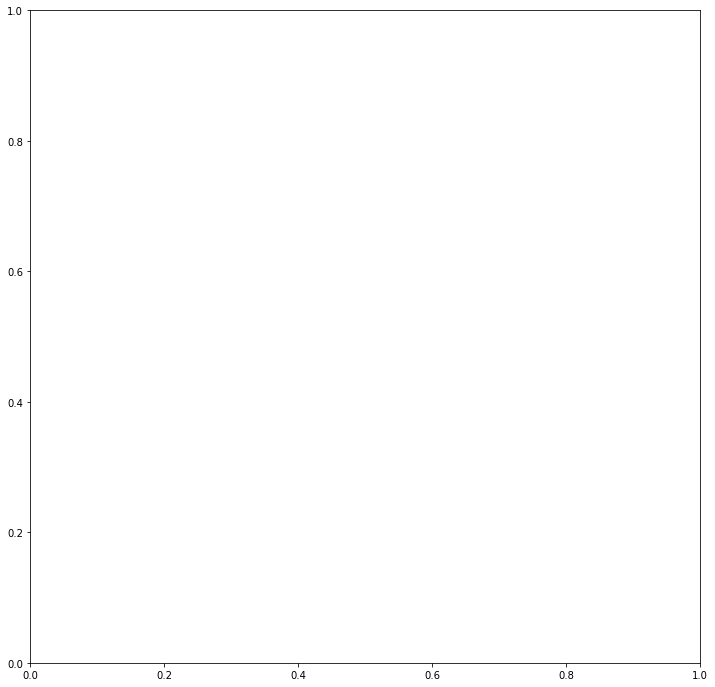

In [812]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    preds_class,
    labels = ['complete before view', 'complete anyway', 'complete responsive', 'incomplete responsive', 'unresponsive'],
    true_labels= ['complete before view', 'complete anyway', 'complete responsive', 'incomplete responsive', 'unresponsive'],
    pred_labels= ['complete before view', 'complete anyway', 'complete responsive', 'incomplete responsive', 'unresponsive'],
    figsize=(12,12))
